# Importing libraries

In [23]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments, DataCollatorWithPadding
from datasets import Dataset, DatasetDict,load_dataset
from sklearn.metrics import mean_squared_error
import torch
import matplotlib.pyplot as plt


# Getting the Data 

In [24]:
import pandas as pd

def excel_to_dict(file_path, sheet_name):
    try:
        # Read the Excel file into a DataFrame
        df = pd.read_excel(file_path, sheet_name=sheet_name)

        # Extract columns
        sentences1 = df['Sentence1'].tolist()
        sentences2 = df['Sentence2'].tolist()
        scores = df['Score'].tolist()

        # Create a dictionary
        data_dict = {
            'sentence1': sentences1,
            'sentence2': sentences2,
            'score': scores
        }

        return data_dict

    except Exception as e:
        print(f"Error: {e}")
        return None

# Example usage
file_path = '/Users/talibulhaq6509/Desktop/finetunedata.xlsx'
sheet_name = 'Sheet1'  # Change this to the name of your sheet
result_dict = excel_to_dict(file_path, sheet_name)

if result_dict:
    print("Dictionary created successfully:")
    print(result_dict)
else:
    print("Failed to create dictionary.")



Dictionary created successfully:
{'sentence1': ['Reinigung erfolgt mit Hilfe von UV-C-Licht', 'Reinigungsbox mit elastischem Reinigungsmaterial (z.B. Borsten, Fäden, Textil, Tücher)', 'Kreislauf, bei dem Sauerstoff am Türgriff vorbeigeleitet wird', 'Zusätzlich Vorsehen einer Reinigungsflüssigkeit z.B. durch Aufsprühen oder Einspülen/Durchspülen', 'Through a comprehensive examination of experimental data utilizing sophisticated biochemical techniques, our findings unequivocally illustrate a pronounced decrease in the catalytic efficiency of the enzyme when exposed to the groundbreaking inhibitory compound, offering profound insights into potential applications for precision medicine and therapeutic advancements in enzymology.', 'im mehrwandigen Kanalabschnitt wird eine Partikelfilterung im Ventinggas bewirkt', 'Ventingkanal in oder an einer Fahrzeugbatterie zur Abführung heißer Gase im Falle einer Überhitzung einer Batteriezelle', 'Im Bereich automatisierter Systeme ist die Integration 

In [25]:
result_dict

{'sentence1': ['Reinigung erfolgt mit Hilfe von UV-C-Licht',
  'Reinigungsbox mit elastischem Reinigungsmaterial (z.B. Borsten, Fäden, Textil, Tücher)',
  'Kreislauf, bei dem Sauerstoff am Türgriff vorbeigeleitet wird',
  'Zusätzlich Vorsehen einer Reinigungsflüssigkeit z.B. durch Aufsprühen oder Einspülen/Durchspülen',
  'Through a comprehensive examination of experimental data utilizing sophisticated biochemical techniques, our findings unequivocally illustrate a pronounced decrease in the catalytic efficiency of the enzyme when exposed to the groundbreaking inhibitory compound, offering profound insights into potential applications for precision medicine and therapeutic advancements in enzymology.',
  'im mehrwandigen Kanalabschnitt wird eine Partikelfilterung im Ventinggas bewirkt',
  'Ventingkanal in oder an einer Fahrzeugbatterie zur Abführung heißer Gase im Falle einer Überhitzung einer Batteriezelle',
  'Im Bereich automatisierter Systeme ist die Integration visueller Wahrnehmu

In [26]:
type(result_dict["score"][0])

float

In [27]:
# Define the tokenizer and model


In [28]:

model_name = "distilbert-base-multilingual-cased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=1)  # Regression: num_labels=1

'(ReadTimeoutError("HTTPSConnectionPool(host='huggingface.co', port=443): Read timed out. (read timeout=10)"), '(Request ID: 8e024b61-09fc-486b-85d6-ff0c8f48c58e)')' thrown while requesting HEAD https://huggingface.co/distilbert-base-multilingual-cased/resolve/main/tokenizer_config.json
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['pre_classifier.weight', 'classifier.weight', 'classifier.bias', 'pre_classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [29]:
# Tokenize the data
tokenized_data = tokenizer(result_dict['sentence1'], result_dict['sentence2'], padding='max_length', truncation=True, return_tensors='pt', max_length=512)

In [30]:
# Create a new Dataset object
dataset = Dataset.from_dict({
    'input_ids': tokenized_data['input_ids'],
    'attention_mask': tokenized_data['attention_mask'],
    'labels': result_dict['score']  # Use similarity scores directly
})

In [135]:
# Define the number of examples for training and evaluation
num_train_examples = 11
num_eval_examples = 3

# Split the dataset into training and evaluation sets
train_dataset = Dataset.from_dict({key: dataset[key][:num_train_examples] for key in dataset.column_names})
eval_dataset = Dataset.from_dict({key: dataset[key][num_train_examples:num_train_examples+num_eval_examples] for key in dataset.column_names})

# Optionally, set the format for PyTorch
train_dataset = train_dataset.with_format("torch")
eval_dataset = eval_dataset.with_format("torch")

In [136]:
# Define a DatasetDict for both training and evaluation datasets
datasets = DatasetDict({'train': train_dataset, 'eval': eval_dataset})

per_device_train_batch_size: The batch size to use during training. It represents the number of training examples utilized in one iteration.

evaluation_strategy: Specifies when to evaluate the model during training. In this case, you've set it to "steps," meaning it will evaluate the model every eval_steps steps.

eval_steps: The number of steps between evaluations when evaluation_strategy is set to "steps." In this example, it's set to 1, so the model will be evaluated every step.

save_steps: The number of steps between consecutive model checkpoints. In this example, it's set to 1, so a checkpoint will be saved after every step.

num_train_epochs: The total number of training epochs (passes through the entire training dataset).

In [158]:
# Define the TrainingArguments for fine-tuning
training_args = TrainingArguments(
    output_dir="./output",
    per_device_train_batch_size=1,
    evaluation_strategy="steps",
    eval_steps=8,
    save_steps=1,
    num_train_epochs=7,
)

In [159]:
# Define the compute_metrics function for MSE
def compute_metrics(p):
    return {"mse": mean_squared_error(p.predictions.flatten(), p.label_ids)}

# Define the Trainer for fine-tuning
trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=DataCollatorWithPadding(tokenizer=tokenizer),
    train_dataset=datasets['train'],
    eval_dataset=datasets['eval'],
    compute_metrics=compute_metrics,
)


In [160]:
# Fine-tune the model----- Lower Training Loss is Better:
trainer.train()





                                               
                                           
  4%|▎         | 4/110 [29:46<03:23,  1.92s/it]


{'eval_loss': 0.3868338167667389, 'eval_mse': 0.3868338167667389, 'eval_runtime': 0.1041, 'eval_samples_per_second': 28.825, 'eval_steps_per_second': 9.608, 'epoch': 0.73}





                                               
                                            
  4%|▎         | 4/110 [30:00<03:23,  1.92s/it]


{'eval_loss': 0.19708330929279327, 'eval_mse': 0.19708330929279327, 'eval_runtime': 0.1044, 'eval_samples_per_second': 28.744, 'eval_steps_per_second': 9.581, 'epoch': 1.45}





                                               
                                            
  4%|▎         | 4/110 [30:15<03:23,  1.92s/it]


{'eval_loss': 0.035210639238357544, 'eval_mse': 0.035210639238357544, 'eval_runtime': 0.1184, 'eval_samples_per_second': 25.341, 'eval_steps_per_second': 8.447, 'epoch': 2.18}





                                               
                                            
  4%|▎         | 4/110 [30:29<03:23,  1.92s/it]


{'eval_loss': 0.06287649273872375, 'eval_mse': 0.06287649273872375, 'eval_runtime': 0.1043, 'eval_samples_per_second': 28.759, 'eval_steps_per_second': 9.586, 'epoch': 2.91}





                                               
                                            
  4%|▎         | 4/110 [30:44<03:23,  1.92s/it]


{'eval_loss': 0.12515513598918915, 'eval_mse': 0.12515513598918915, 'eval_runtime': 0.1038, 'eval_samples_per_second': 28.9, 'eval_steps_per_second': 9.633, 'epoch': 3.64}





                                               
                                            
  4%|▎         | 4/110 [30:58<03:23,  1.92s/it]


{'eval_loss': 0.08359703421592712, 'eval_mse': 0.08359703421592712, 'eval_runtime': 0.1056, 'eval_samples_per_second': 28.404, 'eval_steps_per_second': 9.468, 'epoch': 4.36}





                                               
                                            
  4%|▎         | 4/110 [31:13<03:23,  1.92s/it]


{'eval_loss': 0.07094235718250275, 'eval_mse': 0.07094234973192215, 'eval_runtime': 0.1086, 'eval_samples_per_second': 27.635, 'eval_steps_per_second': 9.212, 'epoch': 5.09}





                                               
                                            
  4%|▎         | 4/110 [31:27<03:23,  1.92s/it]


{'eval_loss': 0.07506650686264038, 'eval_mse': 0.07506650686264038, 'eval_runtime': 0.1034, 'eval_samples_per_second': 29.011, 'eval_steps_per_second': 9.67, 'epoch': 5.82}





                                               
                                            
  4%|▎         | 4/110 [31:41<03:23,  1.92s/it]


{'eval_loss': 0.08197323232889175, 'eval_mse': 0.08197323232889175, 'eval_runtime': 0.1047, 'eval_samples_per_second': 28.648, 'eval_steps_per_second': 9.549, 'epoch': 6.55}


                                               
100%|██████████| 77/77 [02:19<00:00,  1.82s/it]

{'train_runtime': 139.8026, 'train_samples_per_second': 0.551, 'train_steps_per_second': 0.551, 'train_loss': 125.15898944805195, 'epoch': 7.0}


TrainOutput(global_step=77, training_loss=125.15898944805195, metrics={'train_runtime': 139.8026, 'train_samples_per_second': 0.551, 'train_steps_per_second': 0.551, 'train_loss': 125.15898944805195, 'epoch': 7.0})

In [161]:
# Evaluate the fine-tuned model
results = trainer.evaluate()

100%|██████████| 1/1 [00:00<00:00, 419.30it/s]


In [177]:
# Print the evaluation results ------The low evaluation loss and MSE suggest that the model is performing well on your evaluation dataset. Similar values for 'eval_loss' and 'eval_mse' indicate consistency between the loss and the MSE metric.
print(results)

{'eval_loss': 0.08285608887672424, 'eval_mse': 0.08285608887672424, 'eval_runtime': 0.2385, 'eval_samples_per_second': 12.578, 'eval_steps_per_second': 4.193, 'epoch': 7.0}


In [163]:
for log in trainer.state.log_history:
    print(log)

{'eval_loss': 0.3868338167667389, 'eval_mse': 0.3868338167667389, 'eval_runtime': 0.1041, 'eval_samples_per_second': 28.825, 'eval_steps_per_second': 9.608, 'epoch': 0.73, 'step': 8}
{'eval_loss': 0.19708330929279327, 'eval_mse': 0.19708330929279327, 'eval_runtime': 0.1044, 'eval_samples_per_second': 28.744, 'eval_steps_per_second': 9.581, 'epoch': 1.45, 'step': 16}
{'eval_loss': 0.035210639238357544, 'eval_mse': 0.035210639238357544, 'eval_runtime': 0.1184, 'eval_samples_per_second': 25.341, 'eval_steps_per_second': 8.447, 'epoch': 2.18, 'step': 24}
{'eval_loss': 0.06287649273872375, 'eval_mse': 0.06287649273872375, 'eval_runtime': 0.1043, 'eval_samples_per_second': 28.759, 'eval_steps_per_second': 9.586, 'epoch': 2.91, 'step': 32}
{'eval_loss': 0.12515513598918915, 'eval_mse': 0.12515513598918915, 'eval_runtime': 0.1038, 'eval_samples_per_second': 28.9, 'eval_steps_per_second': 9.633, 'epoch': 3.64, 'step': 40}
{'eval_loss': 0.08359703421592712, 'eval_mse': 0.08359703421592712, 'eval

In [ ]:
# Extract eval loss values from the log history
eval_losses = [log["eval_loss"] for log in trainer.state.log_history if "eval_loss" in log]

In [169]:
import seaborn as sns

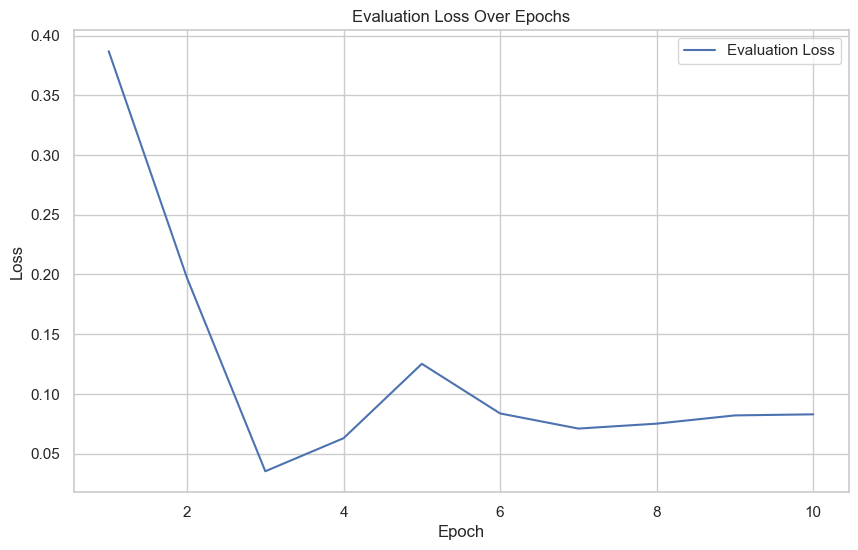

In [170]:
# Create a line plot using seaborn
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.lineplot(x=range(1, len(eval_losses) + 1), y=eval_losses, label='Evaluation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Evaluation Loss Over Epochs')
plt.legend()
plt.show()

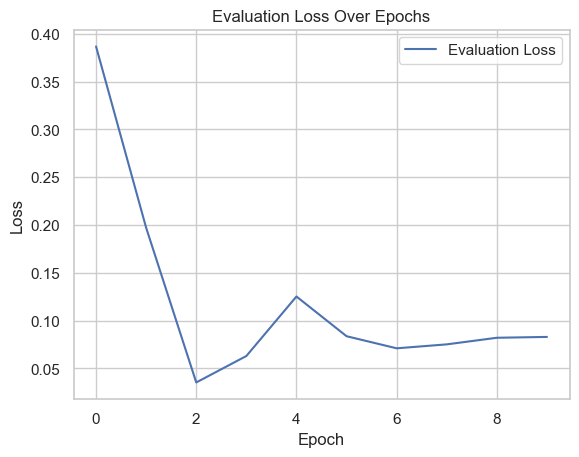

In [171]:


# Plot eval loss over epochs
plt.plot(eval_losses, label='Evaluation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Evaluation Loss Over Epochs')
plt.legend()
plt.show()

In [59]:
eval_losses

{'eval_loss': 0.2799207270145416,
 'eval_mse': 0.279920756816864,
 'eval_runtime': 0.346,
 'eval_samples_per_second': 14.451,
 'eval_steps_per_second': 2.89,
 'epoch': 5.0,
 'step': 10}

In [20]:
# Save the model
trainer.save_model("lab-03-langchain-prompt-template")

In [21]:
# Load the fine-tuned model for later use
loaded_model = AutoModelForSequenceClassification.from_pretrained("lab-03-langchain-prompt-template", num_labels=1)

.........TESTING........

In [172]:
import pandas as pd

def excel_to_dict(file_path, sheet_name):
    try:
        # Read the Excel file into a DataFrame
        df = pd.read_excel(file_path, sheet_name=sheet_name)

        # Extract columns
        sentences1 = df['Sentence1'].tolist()
        sentences2 = df['Sentence2'].tolist()
        scores = df['Score'].tolist()

        # Create a dictionary
        data_dict = {
            'sentence1': sentences1,
            'sentence2': sentences2,
            'score': scores
        }

        return data_dict

    except Exception as e:
        print(f"Error: {e}")
        return None

# Example usage
file_path = '/Users/talibulhaq6509/Desktop/finetunedata.xlsx'
sheet_name = 'Sheet1'  # Change this to the name of your sheet
result_dict = excel_to_dict(file_path, sheet_name)

if result_dict:
    print("Dictionary created successfully:")
    print(result_dict)
else:
    print("Failed to create dictionary.")



Dictionary created successfully:
{'sentence1': ['Reinigung erfolgt mit Hilfe von UV-C-Licht', 'Reinigungsbox mit elastischem Reinigungsmaterial (z.B. Borsten, Fäden, Textil, Tücher)', 'Kreislauf, bei dem Sauerstoff am Türgriff vorbeigeleitet wird', 'Zusätzlich Vorsehen einer Reinigungsflüssigkeit z.B. durch Aufsprühen oder Einspülen/Durchspülen', 'Through a comprehensive examination of experimental data utilizing sophisticated biochemical techniques, our findings unequivocally illustrate a pronounced decrease in the catalytic efficiency of the enzyme when exposed to the groundbreaking inhibitory compound, offering profound insights into potential applications for precision medicine and therapeutic advancements in enzymology.', 'im mehrwandigen Kanalabschnitt wird eine Partikelfilterung im Ventinggas bewirkt', 'Ventingkanal in oder an einer Fahrzeugbatterie zur Abführung heißer Gase im Falle einer Überhitzung einer Batteriezelle', 'Im Bereich automatisierter Systeme ist die Integration 

In [173]:
result_dict

{'sentence1': ['Reinigung erfolgt mit Hilfe von UV-C-Licht',
  'Reinigungsbox mit elastischem Reinigungsmaterial (z.B. Borsten, Fäden, Textil, Tücher)',
  'Kreislauf, bei dem Sauerstoff am Türgriff vorbeigeleitet wird',
  'Zusätzlich Vorsehen einer Reinigungsflüssigkeit z.B. durch Aufsprühen oder Einspülen/Durchspülen',
  'Through a comprehensive examination of experimental data utilizing sophisticated biochemical techniques, our findings unequivocally illustrate a pronounced decrease in the catalytic efficiency of the enzyme when exposed to the groundbreaking inhibitory compound, offering profound insights into potential applications for precision medicine and therapeutic advancements in enzymology.',
  'im mehrwandigen Kanalabschnitt wird eine Partikelfilterung im Ventinggas bewirkt',
  'Ventingkanal in oder an einer Fahrzeugbatterie zur Abführung heißer Gase im Falle einer Überhitzung einer Batteriezelle',
  'Im Bereich automatisierter Systeme ist die Integration visueller Wahrnehmu

# Importing the model from huggingFace

In [174]:
from sentence_transformers import SentenceTransformer, util

# Load the pre-trained model
model2 = SentenceTransformer('distilbert-base-multilingual-cased')

  4%|▎         | 4/110 [51:41<22:49:56, 775.44s/it]
No sentence-transformers model found with name /Users/talibulhaq6509/.cache/torch/sentence_transformers/distilbert-base-multilingual-cased. Creating a new one with MEAN pooling.


In [175]:
# Example data (replace with your actual data)
data = result_dict
# Accumulate MSE values
mse_values = []

# Loop through each data entry
for i in range(len(data['sentence1'])):
    # Encode sentences
    embeddings = model2.encode([data['sentence1'][i], data['sentence2'][i]], convert_to_tensor=True)

    # Calculate cosine similarity
    similarity_score = util.pytorch_cos_sim(embeddings[0], embeddings[1])

    # Calculate MSE
    mse =(data['score'][i] - similarity_score.item())
    mse_values.append(mse)

    # Print similarity score and MSE
    print(f"Similarity Score for '{data['sentence1'][i]}' and '{data['sentence2'][i]}': {similarity_score.item()}")
    print(f"MSE for '{data['sentence1'][i]}' and '{data['sentence2'][i]}': {mse}")

# Calculate average MSE
average_mse = sum(mse_values) / len(mse_values)
print(f"\nAverage MSE for all sentences: {average_mse}")


Similarity Score for 'Reinigung erfolgt mit Hilfe von UV-C-Licht' and ' ultraviolet lamp tube is mounted in the first mounting cavity, viruses can be killed by ozone and ultraviolet rays, the': 0.6268466711044312
MSE for 'Reinigung erfolgt mit Hilfe von UV-C-Licht' and ' ultraviolet lamp tube is mounted in the first mounting cavity, viruses can be killed by ozone and ultraviolet rays, the': 49.37315332889557
Similarity Score for 'Reinigungsbox mit elastischem Reinigungsmaterial (z.B. Borsten, Fäden, Textil, Tücher)' and 'In einer weiteren bevorzugten Ausgestaltungsform einer erfindungsgemäßen Reinigungsvorrichtung kann vorgesehen sein, dass im Reinigungsabschnitt Mittel zum Reinigen und/oder Desinfizieren des Lenkrads vorgesehen sind. Dabei können beispielsweise für eine einfache mechanische Reinigung die Mittel zum Reinigen Bürsten, Schaber oder ähnliches umfassen': 0.7968993186950684
MSE for 'Reinigungsbox mit elastischem Reinigungsmaterial (z.B. Borsten, Fäden, Textil, Tücher)' and 

In [176]:
average_mse

3.43984970501491

In [179]:
results['eval_mse']

0.08285608887672424